# Example: MOOSE wrapper in fiberis

Shenyao Jin, shenyaojin@mines.edu

`fiberis` provides a module to simulate the pressure diffusion using HMM(Hydro-Mechanical Model). `fiberis.moose` is able to control the whole simulation without interacting with the terminal and annoying `.i`, `.e` and `.csv` files!

For this script, I'm going to give a full simulation example so that you can understand the full workflow of `fiberis.moose` module.

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dependence: **MOOSE**.

If you don't know how to install it, refer to my [note](https://shenyaojin.github.io/theory/fiberis-setup/), it will provide instructions on how to install the MOOSE env on UNIX-like systems.

## Import libs

`fiberis.moose` has multiple libs playing different roles of the whole simulation.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

In [27]:
# fiberis modules
from fiberis.moose.model_builder import ModelBuilder
from fiberis.moose.runner import MooseRunner
from fiberis.moose.config import (
    MatrixConfig, SRVConfig, HydraulicFractureConfig, ZoneMaterialProperties,
    SimpleFluidPropertiesConfig, PointValueSamplerConfig, LineValueSamplerConfig, TimeSequenceStepper
)
from fiberis.analyzer.Data1D.Data1D_Gauge import Data1DGauge

## Problem statement

In this case, the PDE problem is a typical and easy problem I will encounter in his research: coupled pressure-strain diffusion:

1. mesh: `200 m` * `200 m` (length * width).
2. Physical field:
    - Hydraulic fracture (HF) has the highest permeability `1e-12` $m^2$, height `0.2 m` width `50 m`. At the center of mesh.
    - Stimulated Reservoir Volume (SRV) has lower permeability, `1e-15` $m^2$, height `20 m` width `80m`. Around the fracture
    - Matrix has the lowest permeability, `1e-17` $m^2$. All other areas not covered by HF and SRV
    - The media flowing in the grid is **water**.
3. 1x injection (source, or boundary condition (B.C.)): at the center of HF, it's defined in pressure (psi or Pa, not in volume).
4. Params to solve: (1). The pressure field, (2) The strain tensor field which is represented in $\varepsilon_{xx}$ and $\varepsilon_{yy}$.
5. Governing equation: the classic HM model. Delete the thermal term in [this paper](https://www.sciencedirect.com/science/article/pii/S1365160909001695). I'm too lazy to use LaTeX to type all the equations. :P
6. Boundaries: 4x Neumann B.C (left, right, top, bottom) and forced pressure at the center of HF.
7. Postprocessor: I'll observe the pressure/strain perpendicular to fracture, and also in multiple points at my interested areas.
8. Executioner: ConstantDT, with mumps preconditioner. The solver is default: `Newton`.
9. Output: the simulation will output a series of `.csv` files, which can be handled by `fiberis` easily.

## Step 1: I/O

First, we need to tell `fiberis` where the results will be stored, where the source `.npz` files (in this case, all data are synthetic) will be read in.

In [28]:
output_dir = "../../output/moose_simulator"
os.makedirs(output_dir, exist_ok=True) # The location of the postprocessor files
input_file_name = os.path.join(output_dir, "example_moose_input_file.i") # Although you don't need to interact with the input file, still needed for the frame.

In [29]:
builder = ModelBuilder(project_name="example_moose") # Select the name you like.

## Step 2: Mesh builder

`fiberis` can generate the moose automatically if you gave the correct parameters. You don't need to set every block manually like what you did in `.i` file.

In [30]:
builder.build_stitched_mesh_for_fractures(
    fracture_y_coords = 0, # the fracture location(s). Make it a list if you want to simulate multiple HFs.
    domain_bounds = (-100, 100), # the total width of the mesh, 200 m as I mentioned in the problem statement, I like to put it like frac = 0, domain bounds = -100 -> 100; you can also set it like frac = 100, bound = 0 -> 200 which would also be fine.
    domain_length = 200, # the toal length of the mesh
    nx = 200, # How many grid you would like to set for the mesh, in **x/length** direction
    ny_per_layer_half = 40, # How many (grid / 2) you would like to set for the mesh, in **y/width** direction
    bias_y = 1.2, # the bias coefficient for y-axis sampling. bias = 1.2 means if the dy_{n-1} = 1 m, then dy_{n} = 1.2 m
)

Info: Successfully built stitched base mesh 'final_stitch_0'.


## Step 3: add elements to the mesh
`fiberis` focus on fracture and SRVs and is able to add them to grid in simple commands.

Here are what we need to do: (1) define the properties of each material, (2) fill out the mesh  with material in (1).

In [31]:
# Define porous materials.
matrix_mats = ZoneMaterialProperties(porosity=0.01, permeability="'1E-17 0 0  0 1E-17 0  0 0 1E-17'")
srv_mats = ZoneMaterialProperties(porosity=0.1, permeability="'1E-15 0 0  0 1E-15 0  0 0 1E-15'")
fracture_mats = ZoneMaterialProperties(porosity=0.1, permeability="'1E-12 0 0  0 1E-12 0  0 0 1E-12'")

In [32]:
center_x_val = 100 # it's domain_length/2, just because I want to put the elements at the center of grid

geometries = [
    SRVConfig(name="SRV", length=80, height=20, center_x=center_x_val, center_y=0, materials=srv_mats),
    HydraulicFractureConfig(name="Fracture", length=50, height=0.2, center_x=center_x_val, center_y=0, materials=fracture_mats)
]

# Fill out the mesh. NOTE: sort them first. The fracture must be set after SRV, or the larger SRV will cover the HF while doing simulation.
sorted_geometries = sorted(geometries, key=lambda x: x.height, reverse=True)
next_block_id = 1
for geom_config in sorted_geometries:
    if isinstance(geom_config, SRVConfig): # If the geometry is SRV, the do SRV configuration
        builder.add_srv_config(geom_config)
        builder.add_srv_zone_2d(geom_config, target_block_id=next_block_id)
    elif isinstance(geom_config, HydraulicFractureConfig): # If the geometry is HF, the do hydraulic fracture configuration
        builder.add_fracture_config(geom_config)
        builder.add_hydraulic_fracture_2d(geom_config, target_block_id=next_block_id)
    next_block_id += 1

# Set the matrix material to all other areas not covered by SRV and HF
builder.set_matrix_config(MatrixConfig(name="matrix", materials=matrix_mats))

In [33]:
# Add the injection/pressure B.C. to the HF
builder.add_nodeset_by_coord(
    nodeset_op_name = "injection", # The name display in DOT "i" file
    new_boundary_name="injection", # The boundary name
    coordinates=(center_x_val, 0, 0) # The location of the injection point
)

In [34]:
# Tel
biot_coeff_val = 0.7 # Biot coefficient
fluid_props = SimpleFluidPropertiesConfig(name="water", bulk_modulus=2.2E9, viscosity=1.0E-3, density0=1000.0) # Water properties
# Viscosity: 1e-3 pa*s
builder.add_fluid_properties_config(fluid_props)
builder.add_poromechanics_materials(
    fluid_properties_name="water", # fluid properties defined above
    biot_coefficient=biot_coeff_val, # Biot coefficient
    solid_bulk_compliance=2E-11 # 1/Pa
)

Info: Added SimpleFluidProperties 'water'.
Info: Added poromechanics materials based on stored configurations.


## Step 4: Add physics to the PDE problem

After defining the mesh in the problem, then is to tell the simulator what physical process is going during the simulation.

In [35]:
# What
builder.add_variables([
    {"name": "pp", "params": {"initial_condition": 0}}, # Initial pressure ~ let's do 0 at this case.
    {"name": "disp_x", "params": {"initial_condition": 0}},
    {"name": "disp_y", "params": {"initial_condition": 0}} # displacement variables in x & y direction
])

Info: Added 3 variables.


In [36]:
# Dictators
builder.set_porous_flow_dictator(dictator_name="dictator", porous_flow_variables="pp") # tell the simulator which variable is pressure
builder.add_global_params({"PorousFlowDictator": "dictator", "displacements": "'disp_x disp_y'"}) # tell the simulator which variables are displacements

Info: Added/Updated UserObject 'dictator'.
Info: Added [GlobalParams] block.


In [37]:
# Add kernels to the simulator. Here are some typical kernels used in HMM.
builder.add_porous_flow_mass_time_derivative_kernel(kernel_name="dt", variable="pp") # time derivative term
builder.add_porous_flow_darcy_base_kernel(kernel_name="flux", variable="pp") # Darcy flow term
builder.add_stress_divergence_tensor_kernel(kernel_name="grad_stress_x", variable="disp_x", component=0) # for x direction
builder.add_stress_divergence_tensor_kernel(kernel_name="grad_stress_y", variable="disp_y", component=1) # for y direction
builder.add_porous_flow_effective_stress_coupling_kernel(kernel_name="eff_stress_x", variable="disp_x", component=0, biot_coefficient=biot_coeff_val) # coupling term
builder.add_porous_flow_effective_stress_coupling_kernel(kernel_name="eff_stress_y", variable="disp_y", component=1, biot_coefficient=biot_coeff_val) # coupling term
builder.add_porous_flow_mass_volumetric_expansion_kernel(kernel_name="mass_exp", variable="pp") # no thermal term

In [38]:
# For the pressure in HFs, use synthetic data
pressure_time = np.linspace(0, 3600, 72) # 72 points, each one is 50s
pressure_val = np.linspace(0, 5000, 72)

dataframe_injection = Data1DGauge()
dataframe_injection.taxis = pressure_time
dataframe_injection.data = pressure_val
dataframe_injection.start_time = datetime.datetime(2025, 1, 1, 0, 0, 0)
dataframe_injection.name = "injection"

In [39]:
# Add this array to the simulator, and it will be the B.C. I will use in the next step
builder.add_piecewise_function_from_data1d(name="injection_pressure_func", source_data1d=dataframe_injection) # The name must be the same as what you will use in the next step

Info: Added PiecewiseConstant Function 'injection_pressure_func' from Data1D source.


In [40]:
# Set up all the BC, including the HF pressure.
builder.set_hydraulic_fracturing_bcs(
    injection_well_boundary_name="injection", # those injection location(s). Use space to separate different HF injection names.
    injection_pressure_function_name="injection_pressure_func", # The name of injection, mentioned in the last block
    confine_disp_x_boundaries="left right", # confine displacement in x direction at left & right boundaries
    confine_disp_y_boundaries="top bottom"  # confine displacement in y direction at top & bottom boundaries
    # left, right, top, bottom are predefined in the simulator.
)

Info: Added Boundary Condition 'injection_pressure'.
Info: Added Boundary Condition 'confinex'.
Info: Added Boundary Condition 'confiney'.
Info: Set standard hydraulic fracturing BCs using predefined set.


In [41]:
# Add aux kernels. In most cases we don't need to do any modifications on it. Just tell the simulator how to convert the displacement to strain & stress.
builder.add_standard_tensor_aux_vars_and_kernels({"stress": "stress", "total_strain": "strain"})

Info: Added standard AuxVariables and AuxKernels for tensors: ['stress', 'total_strain']


## Step 5: Add monitor/postprocessor to the whole problem
After configuring the physics happened in that mesh, we need to sample some of the places which we are interested in. Here I'll add a linear sampler perpendicular to the HF, then do another point sampler near the HF.

In [42]:
builder.add_postprocessor(
    PointValueSamplerConfig(name = "upper_point_sampler", # The name of the sampler, better not use space!
                            variable = "pp",  # The variable I want to monitor; see variables. The aux variables can be also monitored.
                            point = (center_x_val, 30, 0) # Location of the sampler.
                            )
)

builder.add_postprocessor(
    PointValueSamplerConfig(name = "lower_point_sampler",
                            variable = "strain_yy",
                            point = (center_x_val, -30, 0)
                            )
)

builder.add_postprocessor(
    LineValueSamplerConfig( # The linear sampler
        name = "strain_vertical", # The name of the sampler
        variable = "strain_yy", # The variable I want to monitor along the line
        start_point = (center_x_val, -50, 0),
        end_point = (center_x_val, 50, 0), # from -50 m to 50 m
        num_points = 200, # how many points you want to sample along the line
        other_params = {'sort_by': 'y'} # sort the output by y coordinate
    )
)

Info: Added 'upper_point_sampler' to [Postprocessors].
Info: Added 'lower_point_sampler' to [Postprocessors].
Info: Added 'strain_vertical' to [VectorPostprocessors].


In [43]:
# Get the time info of the full simulation
total_time = dataframe_injection.taxis[-1] - dataframe_injection.taxis[0] # total simulation time in seconds
dt_control_func = TimeSequenceStepper() # define the time stepper function
dt_control_func.from_data1d(dataframe_injection) # use the same time steps as the injection data

In [44]:
# Time stepper, I will comment the constDT method, use TimeSequenceStepper
# builder.add_executioner_block(
#     end_time = total_time,
#     dt = total_time / 50,
#     time_stepper_type = 'ConstantDT'
# )

builder.add_executioner_block(
    end_time = total_time,
    dt = total_time / 50, # I remember in sequence stepper you don't need a dt
    time_stepper_type = 'TimeSequenceStepper', # use time sequence stepper
    stepper_config = dt_control_func # pass the time stepper function defined above
)

Info: Configuring with TimeSequenceStepper.
Info: Added [Executioner] block.


In [45]:
# Add the output block: csv files & exodus files
builder.add_preconditioning_block(active_preconditioner='mumps') # Use mumps preconditioner
builder.add_outputs_block(
    exodus = False,
    csv = True # I only need csv files for postprocessing
)

Info: Added [Preconditioning] block with 'mumps' active.
Info: Added [Outputs] block.


## Step 6: render the input file
After all the configurations, now it's time to generate the input file for MOOSE simulator.

In [46]:
# render the input file
builder.generate_input_file(input_file_name) # The input file path defined in Step 1

MOOSE input file generated: ../../output/moose_simulator/example_moose_input_file.i


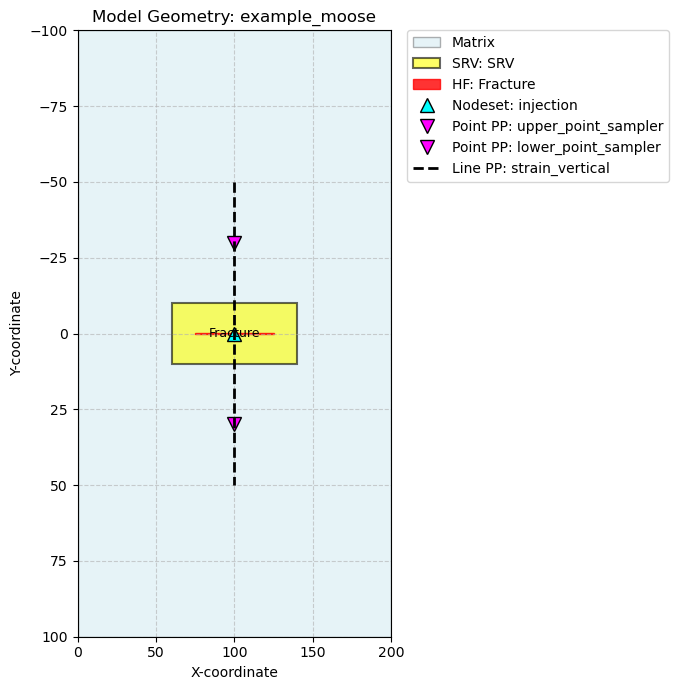

In [47]:
# Plot the geometry of the mesh. I've implemented a simple plot function to visualize the mesh and the elements in it.
builder.plot_geometry() # you can save it if you want. Use optional argument: save_path="your_path.png"

### Step 7: Run the simulation
Now, everything is ready! Just run the simulation using `MooseRunner`.

In [48]:
# 7. Run Simulation
print("\n--- Starting MOOSE Simulation Runner ---")
try:
    moose_executable = "/rcp/rcp42/home/shenyaojin/Documents/bakken_mariner/moose_env/moose/modules/porous_flow/porous_flow-opt" # Update this path to your MOOSE porous_flow executable
    mpiexec_path = "/rcp/rcp42/home/shenyaojin/miniforge/envs/moose/bin/mpiexec" # Update this path to your mpiexec executable
    if not os.path.exists(moose_executable):
        print(f"ERROR: MOOSE executable not found at '{moose_executable}'. Please update the path.")
    else:
        runner = MooseRunner(moose_executable_path=moose_executable, mpiexec_path=mpiexec_path)
        success, stdout, stderr = runner.run(
            input_file_path=input_file_name, # The input file generated in Step 6
            output_directory=output_dir, # The output directory defined in Step 1
            num_processors=20, # Number of processors to use, adjust based on your system
            log_file_name="simulation.log" # Log file name to capture MOOSE output
        )
        if success:
            print("\nSimulation completed successfully!")
        else:
            print("\nSimulation failed.")
            print("--- STDERR from MOOSE ---")
            print(stderr)
except Exception as e:
    print(f"\nAn error occurred during the simulation run: {e}")



--- Starting MOOSE Simulation Runner ---
Output directory '/rcp/rcp42/home/shenyaojin/Documents/bakken_mariner/fibeRIS/examples/output/moose_simulator' exists. Removing it to ensure a clean run.
Staged input file 'example_moose_input_file.i' in working directory '/rcp/rcp42/home/shenyaojin/Documents/bakken_mariner/fibeRIS/examples/output/moose_simulator'
Executing MOOSE command: /rcp/rcp42/home/shenyaojin/miniforge/envs/moose/bin/mpiexec -n 20 /rcp/rcp42/home/shenyaojin/Documents/bakken_mariner/moose_env/moose/modules/porous_flow/porous_flow-opt -i example_moose_input_file.i
Working directory: /rcp/rcp42/home/shenyaojin/Documents/bakken_mariner/fibeRIS/examples/output/moose_simulator
Streaming MOOSE output in real-time...
[DBG] Adding TimeIntegrator 'ImplicitEuler' of type ImplicitEuler
[DBG] Adding UserObject 'water' of type SimpleFluidProperties
[DBG] Adding AuxVariable 'stress_xx' of type MooseVariableConstMonomial
[DBG] Adding AuxVariable 'stress_xy' of type MooseVariableConstMono

## Step 8: visualize the results
After the simulation is done, use visualization tools to see the results.

In [50]:
from fiberis.utils import viz_utils

In [51]:
viz_utils.plot_point_samplers(
    folder = output_dir,
    output_dir = os.path.join(output_dir, "figures")
)

viz_utils.plot_vector_samplers(
    folder = output_dir,
    output_dir = os.path.join(output_dir, "figures")
)

## Results

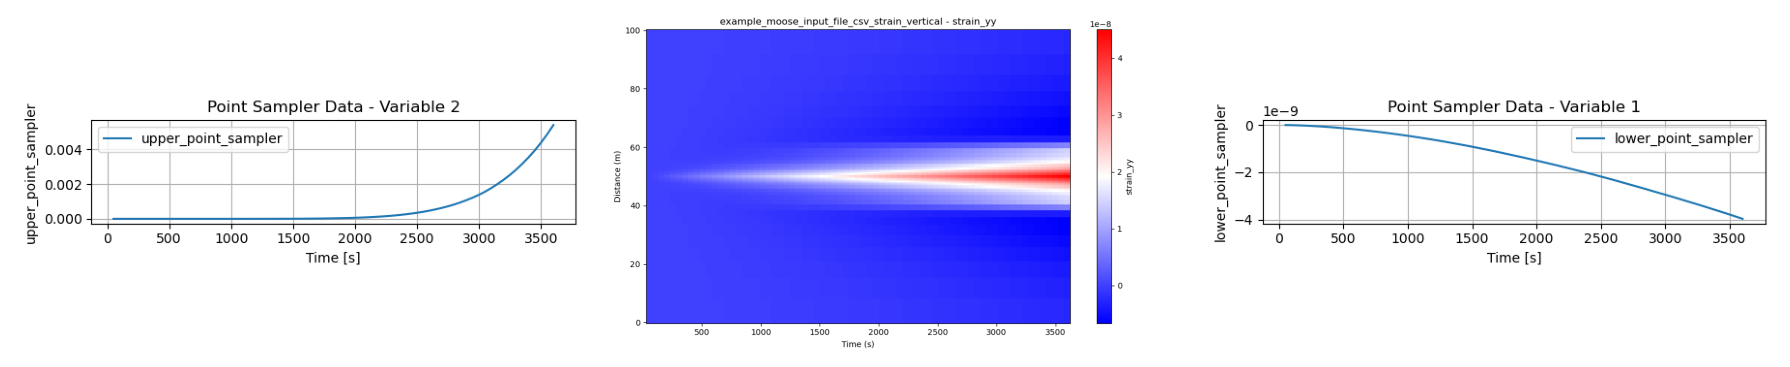

In [55]:
# Display the figures
figures_dir = os.path.join(output_dir, "figures")
fig1_path = os.path.join(figures_dir, "upper_point_sampler.png")
fig2_path = os.path.join(figures_dir, "example_moose_input_file_csv_strain_vertical_var_1.png")
fig3_path = os.path.join(figures_dir, "lower_point_sampler.png")
fig1 = plt.imread(fig1_path)
fig2 = plt.imread(fig2_path)
fig3 = plt.imread(fig3_path)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].imshow(fig1)
axs[0].axis('off')
axs[1].imshow(fig2)
axs[1].axis('off')
axs[2].imshow(fig3)
axs[2].axis('off')
plt.tight_layout()
plt.show()